In [23]:
import awkward as ak
import numpy as np
import pandas as pd
import numba
import glob
from tqdm import tqdm
print(ak.__version__)
from particletools.tables import PYTHIAParticleData as dataname

run_local = True
debug = True
if run_local:
    filepath = "/home/elias/taubus/minbias/V37nano_MinBias_*"
else:
    filepath = "/eos/user/e/eleutgeb/menutools/Phase2-L1MenuTools/cache/V37nano/V37nano_VBFHToTauTau*"

debug = True

files = glob.glob(filepath)

#Get the files:
arrays = [ak.from_parquet(file) for file in files]
# Get the objectnames:
import re
if run_local:
    regex = re.compile(r'^{}|{}$'.format(re.escape("/home/elias/taubus/minbias/V37nano_MinBias_"), re.escape(".parquet")))
else: 
    regex = re.compile(r'^{}|{}$'.format(re.escape("/eos/user/e/eleutgeb/menutools/Phase2-L1MenuTools/cache/V37nano/V37nano_VBFHToTauTau_"), re.escape(".parquet")))


objectnames = [regex.sub("",file) for file in files]
print(objectnames)

2.6.4
['L1TrackMET', 'L1EGbarrel', 'L1puppiExtJetSC4', 'L1TrackTripletWord', 'L1caloJet', 'L1puppiJetSC4sums', 'L1caloTau', 'L1nnCaloTau', 'L1puppiMET', 'L1EGendcap', 'L1TrackHT', 'L1puppiJetHisto', 'L1nnPuppiTau', 'L1puppiJetSC8', 'L1TrackJet', 'L1tkPhoton', 'L1puppiMLMET', 'L1gmtTkMuon', 'L1puppiHistoJetSums', 'L1PV', 'L1hpsTau', 'L1tkElectron', 'L1puppiJetSC4', 'L1gmtMuon']


In [24]:
#Store objects in a dict
objectsdict = dict()
for idx,item in enumerate(objectnames): 
    objectsdict[item] = arrays[idx]

In [25]:
calotaus = objectsdict["L1caloTau"]
nncalotaus = objectsdict["L1nnCaloTau"]
nntaus = objectsdict["L1nnPuppiTau"]
# jets = objectsdict["GenJet"]
# taus = objectsdict["GenVisTau"]
l1jets = objectsdict["L1puppiJetHisto"]
puppijets = objectsdict["L1puppiJetHisto"]
elecsbarrel = objectsdict["L1EGbarrel"]
elecsendcap = objectsdict["L1EGendcap"]
elecsendcap_gt =  ak.pad_none(elecsendcap,6,axis=1,clip=True)
elecsbarrel_gt =  ak.pad_none(elecsbarrel,6,axis=1,clip=True)
muons = objectsdict["L1gmtMuon"]
tkmuons = objectsdict["L1gmtTkMuon"]
met =objectsdict["L1TrackMET"]
calojets = objectsdict["L1caloJet"]
tkele = objectsdict["L1tkElectron"]


In [26]:
calojets.fields
calotaus.fields

['L1caloTau_eta', 'L1caloTau_phi', 'L1caloTau_pt']

In [27]:
#helper functions:
import vector
vector.register_awkward()
x = objectsdict["L1EGbarrel"].fields


def prepare_objects(dictobj):
    fourvectordict = dict()
    standardizeddict = dict()
    vector.register_awkward()

    for key,value in dictobj.items():
        standardizeddict[key] = value
        fields = value.fields
        for field in fields:
            standardname = field.replace(key+"_","")
            standardizeddict[key][standardname] = dictobj[key][field]
            standardizeddict[key] = ak.without_field(standardizeddict[key],field)
            dictobj[key] = ak.without_field(value,field)
        print(key,":",standardizeddict[key].fields)
        fourvectordict[key] =  ak.Array(standardizeddict[key],with_name="Momentum3D")
    return fourvectordict,standardizeddict



    # # combining to numpy
def prepare_for_ml(objects,padlist,namelist,pad_val = 0):
    pad_arrs = []
    var_names = []
    for idx,object in enumerate(objects):
        topad = padlist[idx]
        name = namelist[idx]
        
        if topad == 1:
            pad_arr = object
        else:
            pad_arr = ak.pad_none(object,topad,axis=1,clip=True)
        for i in range(topad):
            for var in object.fields:
                if topad == 1:
                    pad_arrs += [ak.to_numpy(pad_arr[var][:])]
                else:
                    pad_arrs += [ak.to_numpy( ak.fill_none(pad_arr[var][:,i], pad_val) )]
                var_names.append( "{}_{}_{}".format(name, i, var) )
    return var_names, pad_arrs 




In [28]:
padlist = [1,1,5,5,5,5,5]
fourvectordict,standardizeddict = prepare_objects(objectsdict)
objects = [standardizeddict["L1TrackMET"],standardizeddict["L1TrackHT"]]
names = ["L1TrackMET","L1TrackHT"]
# del standardizeddict["L1EGbarrel"]["L1EGbarrel_eta"]
print(standardizeddict["L1EGbarrel"].fields)
inpnames,y = prepare_for_ml(objects,padlist,names)

usecalo = 1
if usecalo:
    v4l1jets = fourvectordict["L1caloJet"]
    v4nntaus = fourvectordict["L1caloTau"]
    l1jets = standardizeddict["L1caloJet"]
    nntaus = standardizeddict["L1caloTau"]
else: 
    v4l1jets = fourvectordict["L1puppiJetHisto"]
    l1jets = standardizeddict["L1puppiJetHisto"]
    v4nntaus = fourvectordict["L1nnPuppiTau"]
    nntaus = standardizeddict["L1nnPuppiTau"]



L1TrackMET : ['pt']
L1EGbarrel : ['eleId', 'phoId', 'saId', 'hwQual', 'eta', 'phi', 'pt']


L1puppiExtJetSC4 : ['pt', 'eta', 'phi', 'btagScore']
L1TrackTripletWord : ['pt']
L1caloJet : ['pt', 'eta', 'phi']
L1puppiJetSC4sums : ['pt', 'phi', 'sumType']
L1caloTau : ['eta', 'phi', 'pt']
L1nnCaloTau : ['hwIso', 'hwQual', 'eta', 'phi', 'pt']
L1puppiMET : ['pt', 'phi']
L1EGendcap : ['eleId', 'phoId', 'saId', 'hwQual', 'eta', 'phi', 'pt']
L1TrackHT : ['ht', 'mht']
L1puppiJetHisto : ['pt', 'eta', 'phi']
L1nnPuppiTau : ['charge', 'id', 'passLooseNN', 'passLooseNNMass', 'passLoosePF', 'passMass', 'passTightNN', 'passTightNNMass', 'passTightPF', 'chargedIso', 'dXY', 'eta', 'fullIso', 'phi', 'pt', 'z0']
L1puppiJetSC8 : ['pt', 'eta', 'phi']
L1TrackJet : ['pt', 'eta', 'phi']
L1tkPhoton : ['eleId', 'phoId', 'saId', 'hwEta', 'hwIso', 'hwPhi', 'hwPt', 'hwQual', 'eta', 'phi', 'pt', 'relIso']
L1puppiMLMET : ['pt']
L1gmtTkMuon : ['charge', 'chargeNoPh', 'hwBeta', 'hwEta', 'hwIso', 'hwPhi', 'hwPt', 'hwQual', 'd0', 'eta', 'phi', 'pt', 'z0']
L1puppiHistoJetSums : ['pt', 'phi', 'sumType']
L1PV : ['z0

In [29]:
# x = nntaus[0][0]
# x.values()
objarray = np.vstack(y)
print(len(objarray[:,0]))
len(inpnames)
for idx,name in enumerate(inpnames):
    print(name,objarray[idx,0])
    
#delta arrays:

import vector
if debug:
    print(len(objarray[:,0]))

len(nntaus)


def objdeltas(obj1,obj2):
    obj1  = obj2



3
L1TrackMET_0_pt 9.46875
L1TrackHT_0_ht 19.0
L1TrackHT_0_mht 12.4375
3


In [30]:

def DeltaRcalc(o1,o2):
    #returns the delta in the dimensions of the second object with delta R  first objects, second
    combo = ak.cartesian({"offl": o1,"trgobj": o2}, nested=True ,axis=-1)
    off,trg = ak.unzip(combo)
    deltaR = off.deltaR(trg)
    return deltaR

def mapObjects(o1,o2):
    combo = ak.cartesian({"offl": o1,"trgobj": o2}, nested=True)
    off,trg = ak.unzip(combo)
    return off,trg


def sortbydeltaR(o1,o2):
    o1cart,o2cart = mapObjects(o1,o2)
    dR = DeltaRcalc(o1,o2)
    sorteddR = ak.argsort(dR)    
    return sorteddR

def dRtonumpy(o1,dr):
    o1dR = o1[dr]
    ttpad = ak.pad_none(o1dR,3,clip=True)
    nptt = ak.to_numpy(ttpad)
    npreg = sructured_to_unstructured(nptt)
    return ak.fill_none(npreg)


In [31]:
#calculate DeltaR:
dr = DeltaRcalc(fourvectordict["L1caloTau"],fourvectordict["L1caloTau"])
# make flat pattern with empty fields, in this case where there are trigger taus and no gen taus:
drleng = ak.num(dr)
emptydr = drleng==0
#calculate the non matched taus,this is used only for the mask:
# Dr_greater = ak.any(dr >= 0.3,axis=-2,keepdims=True, mask_identity=False)  
Dr_smaller = ak.any(dr < 0.3,axis=-2,keepdims=True, mask_identity=False)  
Dr_greater = ~Dr_smaller

temptaus = ak.mask(fourvectordict["L1caloTau"],Dr_greater)
# print("near",v4truetaus[15])
temp_length = ak.num(temptaus,axis=2)
temp_mask = temp_length==0
Dr_greater_flat = ak.flatten(Dr_greater,axis=-1)
falsepattern = ak.where(emptydr,temp_mask,Dr_greater_flat)
nntaus_no_near_taus = falsepattern
nntaus_near_taus = ~ nntaus_no_near_taus
tt = ak.mask(standardizeddict["L1caloTau"],falsepattern)


# nntaus_near_taus = ak.any(dr < 3,axis=1,keepdims=True, mask_identity=False)  
# nntaus_no_near_taus = ak.any(dr >= 3,axis=1,keepdims=True, mask_identity=False)  

#we also have to check where there are no hadronic taus in the event
#done by counting dr values and then masking the list
# drleng = ak.num(dr)
# emptydr = ak.any(drleng == 0,axis=0, keepdims=True, mask_identity=False)
# nntaus_near_taus = ak.any((dr < 0.3),axis=1)
v4truetaus = ak.drop_none(ak.mask(fourvectordict["L1caloTau"],nntaus_near_taus),axis=1)
v4falsetaus =  ak.drop_none(ak.mask(fourvectordict["L1caloTau"],nntaus_no_near_taus),axis=1)
combo = ak.cartesian({"trgobj": v4truetaus,"offl": v4l1jets}, nested=True)
offmu,trgobj = ak.unzip(combo)
deltaRl1jets_nnTaus = offmu.deltaR(trgobj) #magic?!
truejets = l1jets[ak.argmin(deltaRl1jets_nnTaus,axis=-1)]
combo = ak.cartesian({"trgobj": v4falsetaus,"offl": v4l1jets}, nested=True)
offmu,trgobj = ak.unzip(combo)
deltaRl1jets_nnTaus = offmu.deltaR(trgobj) #magic?!
falsejets = l1jets[ak.argmin(deltaRl1jets_nnTaus,axis=-1)]
truetaus = ak.drop_none(ak.mask(standardizeddict["L1caloTau"],nntaus_near_taus),axis=1)
falsetaus = ak.drop_none(ak.mask(standardizeddict["L1caloTau"],nntaus_no_near_taus),axis=1)
print(v4truetaus[15])
# test =  + ak.mask(standardizeddict["L1caloTau"],emptydr)  
# falsetaus = ak.concatenate(falsetaus,ak.drop_none(test,axis=-1),axis=1)


[{eta: -2.65, phi: -1.44, pt: 39.9}, {...}, ..., {eta: -0.306, phi: 0.131, ...}]


In [32]:
nntaus_near_taus



<Array [[True], [True], ..., [], [True, True]] type='1747709 * var * bool'>

In [33]:

# muonstrue,b = ak.broadcast_arrays(standardizeddict["L1gmtMuon"],v4truetaus, depth_limit=1)
# v4muonstrue,b = ak.broadcast_arrays(fourvectordict["L1gmtMuon"],v4truetaus, depth_limit=2)
# test = ak.drop_none(v4muonstrue)
# drmu = DeltaRcalc(v4truetaus,fourvectordict["L1gmtMuon"])
# test = ak.argsort(drmu)
# test.type.show()
# drmu.type.show()

# b.type.show()
# x = fourvectordict["L1gmtMuon"]
# v4muonstrue[test]
# for l in range(len(drmu)):
#     tt = fourvectordict["L1gmtMuon"][l]
#     print(l)
#     tt[test[l]]
# fourvectordict["L1gmtMuon"][547]
# standardizeddict["L1gmtMuon"][ak.argsort(deltartaumuons,axis=1)]

def PrepareReldR(a,b,c,d,sort):
    f,g = mapObjects(a,b)
    drmu = DeltaRcalc(c,d)
    tts = ak.argsort(drmu)
    muonssorted = g[tts]
    # test = ak.any(nntaus_near_taus,axis=1)
    mm = ak.flatten(muonssorted[ak.any(sort,axis=1)],axis=1)
    return mm
# v4l1jets = fourvectordict["L1puppiJetHisto"]

removal = ["L1gmtMuon",
"L1gmtTkMuon",
"L1tkPhoton",
"L1tkElectron",
]
for i in removal:
    print("before",standardizeddict[i].fields)
    standardizeddict[i] = ak.without_field(standardizeddict[i],'pt')
    standardizeddict[i] = ak.without_field(standardizeddict[i],'eta')
    standardizeddict[i] = ak.without_field(standardizeddict[i],'phi')
    if 'd0' in standardizeddict[i].fields:
        standardizeddict[i] = ak.without_field(standardizeddict[i],'d0')
    if 'z0' in standardizeddict[i].fields:
        standardizeddict[i] = ak.without_field(standardizeddict[i],'z0')
    print("after",standardizeddict[i].fields)
# truecalojets = PrepareReldR(truetaus,standardizeddict["L1caloJet"],v4truetaus,fourvectordict["L1caloJet"],nntaus_near_taus)
# falsecalojets = PrepareReldR(falsetaus,standardizeddict["L1caloJet"],v4falsetaus,fourvectordict["L1caloJet"],~nntaus_near_taus)
truemuons = PrepareReldR(truetaus,standardizeddict["L1gmtMuon"],v4truetaus,fourvectordict["L1gmtMuon"],nntaus_near_taus)
falsemuons = PrepareReldR(falsetaus,standardizeddict["L1gmtMuon"],v4falsetaus,fourvectordict["L1gmtMuon"],~nntaus_near_taus)
truetkmuons = PrepareReldR(truetaus,standardizeddict["L1gmtTkMuon"],v4truetaus,fourvectordict["L1gmtTkMuon"],nntaus_near_taus)
falsetkmuons = PrepareReldR(falsetaus,standardizeddict["L1gmtTkMuon"],v4falsetaus,fourvectordict["L1gmtTkMuon"],~nntaus_near_taus)
trueg = PrepareReldR(truetaus,standardizeddict["L1tkPhoton"],v4truetaus,fourvectordict["L1tkPhoton"],nntaus_near_taus)
falseg = PrepareReldR(falsetaus,standardizeddict["L1tkPhoton"],v4falsetaus,fourvectordict["L1tkPhoton"],~nntaus_near_taus)
trueeles = PrepareReldR(truetaus,standardizeddict["L1tkElectron"],v4truetaus,fourvectordict["L1tkElectron"],nntaus_near_taus)
falseeles = PrepareReldR(falsetaus,standardizeddict["L1tkElectron"],v4falsetaus,fourvectordict["L1tkElectron"],~nntaus_near_taus)
truej = PrepareReldR(truetaus,standardizeddict["L1puppiJetHisto"],v4truetaus,fourvectordict["L1puppiJetHisto"],nntaus_near_taus)
falsej = PrepareReldR(falsetaus,standardizeddict["L1puppiJetHisto"],v4falsetaus,fourvectordict["L1puppiJetHisto"],~nntaus_near_taus)
truecaloeb = PrepareReldR(truetaus,standardizeddict["L1EGbarrel"],v4truetaus,fourvectordict["L1EGbarrel"],nntaus_near_taus)
falsecaloeb = PrepareReldR(falsetaus,standardizeddict["L1EGbarrel"],v4falsetaus,fourvectordict["L1EGbarrel"],~nntaus_near_taus)
truecaloee = PrepareReldR(truetaus,standardizeddict["L1EGendcap"],v4truetaus,fourvectordict["L1EGendcap"],nntaus_near_taus)
falsecaloee = PrepareReldR(falsetaus,standardizeddict["L1EGendcap"],v4falsetaus,fourvectordict["L1EGendcap"],~nntaus_near_taus)

tobemapped = [truemuons,trueeles,trueg,truej,truecaloeb,truecaloee, truetkmuons]
ls = truemuons.fields + trueeles.fields + trueg.fields + truej.fields + truecaloeb.fields + truecaloee.fields + truetkmuons.fields
names = ["L1gmtMuon",
"L1gmtTkMuon",
"L1tkPhoton",
"L1tkElectron",
"L1puppiJetHisto",
"L1EGbarrel",
"L1EGendcap"]
#remove non physical vals:

padlist = [5,5,5,5,5,5,5,5]
drtruenames, drtruevals = prepare_for_ml(tobemapped,padlist,names)


tobemapped = [falsemuons,falseeles,falseg,falsej,falsecaloeb,falsecaloee, falsetkmuons]
for item in tobemapped:
    print(len(item))
ls = falsemuons.fields + falseeles.fields  + falseg.fields + falsej.fields + falsecaloeb.fields + falsecaloee.fields + falsetkmuons.fields
#padlist = [5,5,5,5]
drfnames, temp = prepare_for_ml(tobemapped,padlist,names)

drfvals = np.vstack(temp)
drtruevals = np.vstack(drtruevals)
drtruevals =np.swapaxes(drtruevals,0,1)
drfvals =np.swapaxes(drfvals,0,1)
drfvals = ak.to_numpy(drfvals)
drtruevals = ak.to_numpy(drtruevals)

from numpy.lib.recfunctions import structured_to_unstructured
# drfvals = structured_to_unstructured(drfvals)
# drtruevals = structured_to_unstructured(drtruevals)

# f,g = mapObjects(truetaus,standardizeddict["L1gmtMuon"])
# drmu = DeltaRcalc(v4truetaus,fourvectordict["L1gmtMuon"])
# # tt = f.deltaR(g)
# tts = ak.argsort(drmu)
# # bb,muons = ak.unzip(ak.cartesian([truetaus,standardizeddict["L1gmtMuon"]]))
# muonssorted = g[tts]
# # test = ak.any(nntaus_near_taus,axis=1)
# mm = ak.flatten(muonssorted[ak.any(nntaus_near_taus,axis=1)],axis=1)
# mm.type.show()
# ttflat = ak.flatten(truetaus)
# ttflat.type.show()


before ['charge', 'chargeNoPh', 'hwBeta', 'hwEta', 'hwIso', 'hwPhi', 'hwPt', 'hwQual', 'd0', 'eta', 'phi', 'pt', 'z0']
after ['charge', 'chargeNoPh', 'hwBeta', 'hwEta', 'hwIso', 'hwPhi', 'hwPt', 'hwQual']
before ['charge', 'chargeNoPh', 'hwBeta', 'hwEta', 'hwIso', 'hwPhi', 'hwPt', 'hwQual', 'd0', 'eta', 'phi', 'pt', 'z0']
after ['charge', 'chargeNoPh', 'hwBeta', 'hwEta', 'hwIso', 'hwPhi', 'hwPt', 'hwQual']
before ['eleId', 'phoId', 'saId', 'hwEta', 'hwIso', 'hwPhi', 'hwPt', 'hwQual', 'eta', 'phi', 'pt', 'relIso']
after ['eleId', 'phoId', 'saId', 'hwEta', 'hwIso', 'hwPhi', 'hwPt', 'hwQual', 'relIso']
before ['eleId', 'phoId', 'saId', 'hwEta', 'hwIso', 'hwPhi', 'hwPt', 'hwQual', 'charge', 'eta', 'phi', 'pt', 'relIso', 'z0']
after ['eleId', 'phoId', 'saId', 'hwEta', 'hwIso', 'hwPhi', 'hwPt', 'hwQual', 'charge', 'relIso']
0
0
0
0
0
0
0


In [34]:
truejetsnames = ["calojets_" + i for i in truejets.fields]
truetausnames = ["calotaus_" + i for i in truetaus.fields]

names = truejetsnames + truetausnames + inpnames + drfnames
print(len(names))
print(names)

269
['calojets_pt', 'calojets_eta', 'calojets_phi', 'calotaus_eta', 'calotaus_phi', 'calotaus_pt', 'L1TrackMET_0_pt', 'L1TrackHT_0_ht', 'L1TrackHT_0_mht', 'L1gmtMuon_0_charge', 'L1gmtMuon_0_chargeNoPh', 'L1gmtMuon_0_hwBeta', 'L1gmtMuon_0_hwEta', 'L1gmtMuon_0_hwIso', 'L1gmtMuon_0_hwPhi', 'L1gmtMuon_0_hwPt', 'L1gmtMuon_0_hwQual', 'L1gmtMuon_1_charge', 'L1gmtMuon_1_chargeNoPh', 'L1gmtMuon_1_hwBeta', 'L1gmtMuon_1_hwEta', 'L1gmtMuon_1_hwIso', 'L1gmtMuon_1_hwPhi', 'L1gmtMuon_1_hwPt', 'L1gmtMuon_1_hwQual', 'L1gmtMuon_2_charge', 'L1gmtMuon_2_chargeNoPh', 'L1gmtMuon_2_hwBeta', 'L1gmtMuon_2_hwEta', 'L1gmtMuon_2_hwIso', 'L1gmtMuon_2_hwPhi', 'L1gmtMuon_2_hwPt', 'L1gmtMuon_2_hwQual', 'L1gmtMuon_3_charge', 'L1gmtMuon_3_chargeNoPh', 'L1gmtMuon_3_hwBeta', 'L1gmtMuon_3_hwEta', 'L1gmtMuon_3_hwIso', 'L1gmtMuon_3_hwPhi', 'L1gmtMuon_3_hwPt', 'L1gmtMuon_3_hwQual', 'L1gmtMuon_4_charge', 'L1gmtMuon_4_chargeNoPh', 'L1gmtMuon_4_hwBeta', 'L1gmtMuon_4_hwEta', 'L1gmtMuon_4_hwIso', 'L1gmtMuon_4_hwPhi', 'L1gmtMuon_4

In [35]:
#prepare trues:
#broadcast other objects to the form of truetaus:
#first flip axis
objswapped =np.swapaxes(objarray,0,1)
objswappedak = ak.Array(objswapped)
#output arrays
tobj,b = ak.broadcast_arrays(objswappedak[:,np.newaxis],truetaus)
tobjflat =ak.flatten(tobj)
nptobjflat = ak.to_numpy(tobjflat)
#transform truetaus to numpy
ttflat = ak.flatten(truetaus)
npttflat = ak.to_numpy(ttflat)
tjflat = ak.flatten(truejets)
nptjflat = ak.to_numpy(tjflat)

from numpy.lib.recfunctions import structured_to_unstructured
unstructuredtruetaus = structured_to_unstructured(npttflat)
unstructuredtruejets = structured_to_unstructured(nptjflat)


In [36]:

trues = np.concatenate((unstructuredtruejets,unstructuredtruetaus,nptobjflat,drtruevals),axis=1)

#prepare trues:
#broadcast other objects to the form of truetaus:
#first flip axis
objswapped =np.swapaxes(objarray,0,1)
objswappedak = ak.Array(objswapped)
#output arrays
tobj,b = ak.broadcast_arrays(objswappedak[:,np.newaxis],falsetaus)
tobjflat =ak.flatten(tobj)
nptobjflat = ak.to_numpy(tobjflat)
#transform truetaus to numpy
ttflat = ak.flatten(falsetaus)
npttflat = ak.to_numpy(ttflat)
tjflat = ak.flatten(falsejets)
nptjflat = ak.to_numpy(tjflat)

from numpy.lib.recfunctions import structured_to_unstructured
unstructuredtruetaus = structured_to_unstructured(npttflat)
unstructuredtruejets = structured_to_unstructured(nptjflat)

falses = np.concatenate((unstructuredtruejets,unstructuredtruetaus,nptobjflat,drfvals),axis=1)
x_sig = trues
x_bkg = falses

 # creating labels
y_bkg = np.zeros(len(x_bkg))
y_sig = np.ones(len(x_sig))

# combining signal & bkg
x = np.concatenate((x_bkg, x_sig))
y = np.concatenate((y_bkg, y_sig))


In [39]:

x_sig

masked_array(
  data=[[42.2421875 , -0.56750488,  2.8359375 , ...,  0.        ,
          0.        ,  0.        ],
        [44.1953125 ,  1.26586914,  0.65454102, ...,  0.        ,
          0.        ,  0.        ],
        [30.48046875, -0.8293457 ,  2.3125    , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [42.7265625 , -0.74206543,  1.17797852, ...,  0.        ,
          0.        ,  0.        ],
        [76.734375  , -2.65332031, -2.48730469, ...,  0.        ,
          0.        ,  0.        ],
        [42.1953125 ,  0.21826172, -2.22509766, ...,  0.        ,
          0.        ,  0.        ]],
  mask=False,
  fill_value=1e+20)

In [14]:

from pickle import load
from sklearn.preprocessing import StandardScaler
inpath = "/home/elias/taubus/outputs_for_training_2024_08_16-05_41_00_PM/"

scaler = load(open("/home/elias/taubus/outputs_for_training_2024_08_16-05_41_00_PM/scaler.pkl", 'rb'))
x_scaled = scaler.transform(x)
import os
from datetime import datetime

datenow = datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
outdir = "minbias_outputs_for_rate_{}/".format(datenow)
if not os.path.exists(outdir):
    os.makedirs(outdir)

print("outdir:  ",outdir)
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=0.4)
print(X_train.shape[1])
from sklearn.utils.class_weight import compute_class_weight

#weighing trues and false
class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)

# Convert class_weights to a dictionary
class_weight_dict = dict(enumerate(class_weights))
print(class_weight_dict)


outdir:   minbias_outputs_for_rate_2024_08_19-10_54_29_AM/
269
{0: 1.0}


In [15]:

from keras.models import load_model

# save_dir = 'models_20240816_123456'  # Replace with your directory
# model_name = 'model_cloned_1'  # Replace with your model name
# model_path = os.path.join(save_dir, model_name)
loaded_model = load_model("/home/elias/taubus/models_20240817_124429/lrs2.keras")
predictions = loaded_model.predict((x_scaled))

2024-08-19 10:54:46.125989: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-19 10:54:46.730195: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-19 10:54:46.732529: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-19 10:54:47.888615: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2024-08-19 10:54:57.346281: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1908919764 exceeds 10% of free system memory.


55441/55441 [==============================] - 63s 1ms/step


In [16]:
xx = ak.unflatten(predictions,ak.num(standardizeddict["L1caloTau"]))
for i in range(1000):
    if len(standardizeddict["L1caloTau"][i]) != len(xx[i]):
        print(i,len(standardizeddict["L1caloTau"][i]))
        print(len(xx[i]))



minbias_outputs_for_rate_2024_08_19-10_54_29_AM/


In [19]:
def m2tex(model):
    stringlist = []
    model.summary(line_length=70, print_fn=lambda x: stringlist.append(x))
    del stringlist[1:-4:2]
    del stringlist[-1]
    for ix in range(1,len(stringlist)-3):
        tmp = stringlist[ix]
        stringlist[ix] = tmp[0:31]+"& "+tmp[31:59]+"& "+tmp[59:]+"\\\\ \hline"
    stringlist[0] = "Model: test \\\\ \hline"
    stringlist[1] = stringlist[1]+" \hline"
    stringlist[-4] = stringlist[-4]+" \hline"
    stringlist[-3] = stringlist[-3]+" \\\\"
    stringlist[-2] = stringlist[-2]+" \\\\"
    stringlist[-1] = stringlist[-1]+" \\\\ \hline"
    prefix = ["\\begin{table}[]", "\\begin{tabular}{lll}"]
    suffix = ["\end{tabular}", "\caption{Model summary for test.}", "\label{tab:model-summary}" , "\end{table}"]
    stringlist = prefix + stringlist + suffix 
    out_str = " \n".join(stringlist)
    out_str = out_str.replace("_", "\_")
    out_str = out_str.replace("#", "\#")
    print(out_str)


m2tex(loaded_model)

\begin{table}[] 
\begin{tabular}{lll} 
Model: test \\ \hline 
 Layer (type)                  & Output Shape                & Param \#    \\ \hline \hline 
 fc1 (Dense)                   & (None, 192)                 & 51840      \\ \hline 
 relu1 (Activation)            & (None, 192)                 & 0          \\ \hline 
 dropout (Dropout)             & (None, 192)                 & 0          \\ \hline 
 fc2 (Dense)                   & (None, 384)                 & 74112      \\ \hline 
 relu2 (Activation)            & (None, 384)                 & 0          \\ \hline 
 dropout\_1 (Dropout)           & (None, 384)                 & 0          \\ \hline 
 fc3 (Dense)                   & (None, 144)                 & 55440      \\ \hline 
 relu3 (Activation)            & (None, 144)                 & 0          \\ \hline 
 dropout\_2 (Dropout)           & (None, 144)                 & 0          \\ \hline 
 output (Dense)                & (None, 1)                   & 145        \\ \

In [ ]:

xyz = ak.flatten(xx,axis=-1)
outp = ak.with_field(standardizeddict["L1caloTau"],xyz,"gtscore")
yx = ak.unflatten(y,ak.num(standardizeddict["L1caloTau"]))
ak.to_parquet(outp, outdir+"V37Nano_minbias_Calotaus_gt_score_V3.parquet")
print(outdir)
yxx = ak.max(yx,axis= -1)
xxx = ak.max(xx,axis=-1)

xxx2 = ak.min(xx,axis=-1)


In [ ]:
print(yxx)

print(xxx)

In [48]:
mask = (ak.mask(outp.gtscore,outp.gtscore > 0.15))
count = ak.num(mask,axis=-1)
mask = ak.drop_none(mask)
count = ak.num(mask,axis=-1)
# masked_gtscore = [outp.gtscore > 0.15]
# masked_gtscore_flat = ak.flatten(masked_gtscore,axis=-1)
# gtcounts = ak.num(masked_gtscore)


Text(0, 0.5, 'Frequency')

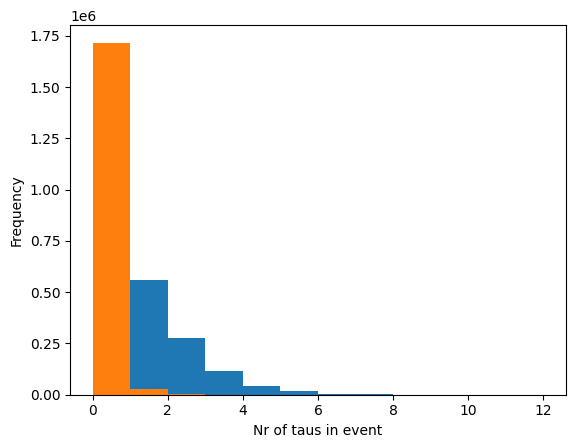

In [59]:
calotaus_mask = ak.num(standardizeddict["L1caloTau"],axis=-1)

ak.max(calotaus_mask)
plt.hist(calotaus_mask, bins=12)  # Adjust the number of bins as needed
plt.hist(count,bins=ak.max(count))

plt.xlabel('Nr of taus in event')
plt.ylabel('Frequency')

In [61]:
print(len(calotaus_mask))
print(len(count))

1747709
1747709


In [65]:
ak.max(count)

5

In [ ]:
ak.max(coutn)

Text(0, 0.5, 'Occurrences')

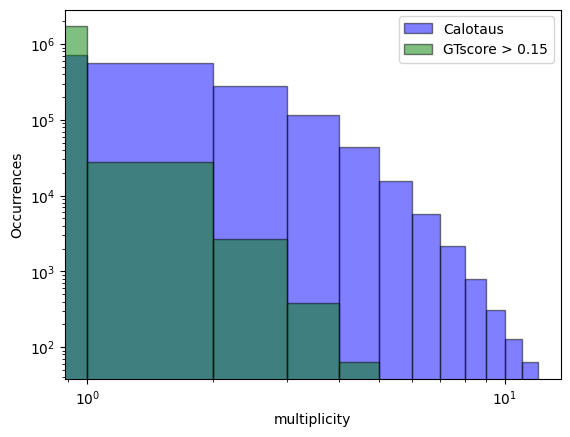

In [68]:
plt.hist(calotaus_mask, bins=12, alpha=0.5, label='Calotaus', color='blue', edgecolor='black')
plt.hist(count, bins=ak.max(count), alpha=0.5, label='GTscore > 0.15', color='green', edgecolor='black')

# Adding labels and title
plt.legend()
plt.loglog()
plt.xlabel('multiplicity')
plt.ylabel('Occurrences')
# plt.title('')

ValueError: The number of FixedLocator locations (6), usually from a call to set_ticks, does not match the number of labels (13).

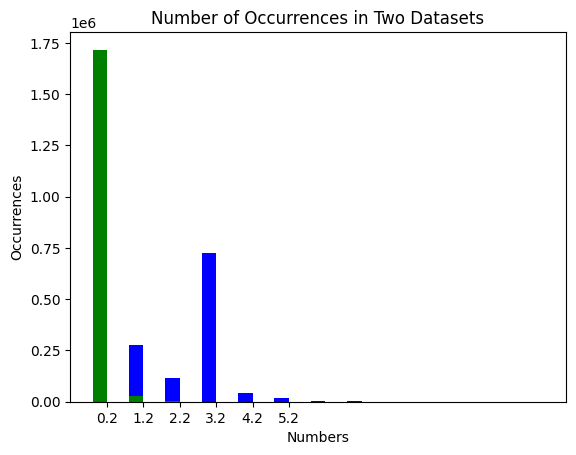

In [67]:
from collections import Counter
occurrences1 = Counter(calotaus_mask)
occurrences2 = Counter(count)

# Extract the keys (unique numbers) and values (counts) for both datasets
x1 = list(occurrences1.keys())
y1 = list(occurrences1.values())

x2 = list(occurrences2.keys())
y2 = list(occurrences2.values())

# Plotting the first dataset
bar_width = 0.4  # Width of the bars
index = np.arange(len(x1))

plt.bar(index, y1, bar_width, label='Calotaus', color='blue')
index = np.arange(len(x2))

# Plotting the second dataset, with an offset for clarity
plt.bar(index, y2, bar_width, label='GTscore > 0.15', color='green')

# Adding labels and title
plt.xlabel('Numbers')
plt.ylabel('Occurrences')
plt.title('Number of Occurrences in Two Datasets')

# Adjusting the x-ticks to show the correct labels
plt.xticks(index + bar_width / 2, x1)

# Adding a legend
plt.legend()

# Display the plot
plt.show()

Text(0, 0.5, 'Frequency')

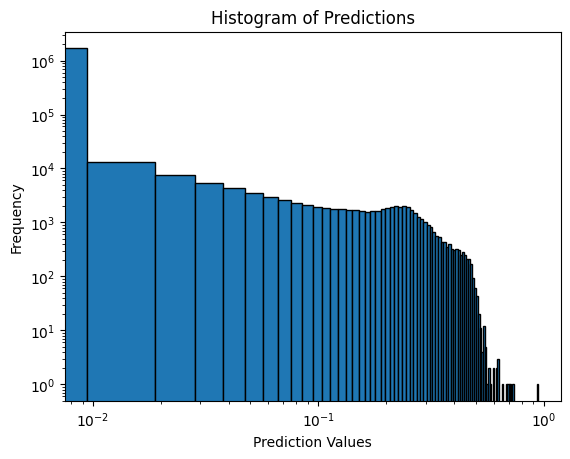

In [18]:
import matplotlib.pyplot as plt
plt.hist(predictions, bins=100, edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram of Predictions')
plt.loglog()
plt.xlabel('Prediction Values')
plt.ylabel('Frequency')
/home/elias/taubus/V37nano/V37nano_VBFHToTauTau_GenJetAK8.parquet

In [ ]:
xxxpad = ak.pad_none(xxx,1,axis=-1)
xxxfill = ak.fill_none(xxxpad,0,axis=-1)
yxxfill = ak.fill_none(yxx,1)
print(xxxfill)
print(0)


xxxpad2 = ak.pad_none(xxx2,1,axis=-1)
xxxfill2 = ak.fill_none(xxxpad2,0,axis=-1)
# yxxfill2 = ak.fill_none(yxx2,1)
print(xxxfill2)
# y_flat = ak.flatten(yxxfill,axis = None)
x_flat2 = ak.flatten(xxxfill2,axis = None)
# y_test = np.zeros(len(x_flat))
print(0)

In [ ]:
len(standardizeddict["L1caloTau"])
len(xxxfill)
def totalMinBiasRate(nCollBunch = 2500):
    LHCfreq = 11245.6
    return LHCfreq * nCollBunch / 1e3

In [ ]:
print(xxxfill)

In [ ]:
y_flat = ak.flatten(yxxfill,axis = None)
x_flat = ak.flatten(xxxfill,axis = None)
y_test = np.zeros(len(x_flat))

In [ ]:

from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
fpr2, tpr2, thr2 = roc_curve( y_test, x_flat, drop_intermediate=False)
fpr, tpr, thr = roc_curve( y_test, x_flat2, drop_intermediate=False)

# plt.plot(fpr2 * totalMinBiasRate() ,thr2 * -1)

plt.plot(fpr2 * totalMinBiasRate(), thr2 , label ="max")

plt.xlabel("FPR*MBrate: Trigger rate [kHz]")
plt.ylabel("NN threshhold (1 -x)")
plt.xscale("log")
plt.grid()
plt.xlim(0,1000)
plt.show()
plt.plot(fpr * totalMinBiasRate(), thr , label ="min")

plt.xlabel("FPR*MBrate: Trigger rate [kHz]")
plt.ylabel("NN threshhold (1 -x)")
plt.xscale("log")
plt.grid()
plt.xlim(0,1000)


In [ ]:
, drop_intermediate=False)

plt.plot(fpr1, tpr1)
